In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import parent
import networks

In [2]:
from collections import OrderedDict
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import network_wrappers
import data
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r_ds = torch.load("/playpen/tgreer/knees_real_train_set_hires")
batched_ds = list(zip(*[r_ds[i::4] for i in range(4)]))


In [4]:
BATCH_SIZE = 4
SCALE = 2  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

GPUS = 1


phi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet(unet=networks.UNet2ChunkyMiddle, dimension=3)
)
psi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet2(dimension=3)
)



/playpen-raid1/tgreer/InverseConsistency/networks.py:483: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([[2, 16, 32, 64, 256, 512], [16, 32, 64, 128, 256]]),


In [5]:
net = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DoubleNet(
        network_wrappers.DownsampleNet(network_wrappers.DoubleNet(phi, psi), dimension=3), 
        network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=3)),
    ),
    lambda x, y: torch.mean((x - y) ** 2),
    100
)

network_wrappers.assignIdentityMap(net, input_shape)

In [6]:
#weights = torch.load("../results/hires_ncc_70000_6/knee_aligner_resi_net4200")
weights = torch.load("../results/hires_frozen_lowres_3/knee_aligner_resi_net10800")
net.load_state_dict(weights)

<All keys matched successfully>

In [7]:
network_wrappers.adjust_batch_size(net, 4)
net.cuda()
net.eval()
0

0

In [9]:
def flips(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True)
    return torch.sum(dV < 0) / 3

dices = []
folds_list = []
for x in batched_ds[:]:
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = x[0], x[2]
    moving_image, moving_cartilage = x[1], x[3]
    
    net(moving_image, fixed_image)
    fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB(net.identityMap)[:, :3])
    sz = np.array(fat_phi.size())
    spacing = 1./(sz[2::]-1) 
    warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
    wmb = warped_moving_cartilage > .5
    fb = fixed_cartilage > .5
    intersection = wmb * fb
    d = 2 * torch.sum(intersection, [1,2,3,4]).float() / (torch.sum(wmb, [1,2,3,4]) + torch.sum(fb, [1,2,3,4]))
    print(d)
    dices.append(d)
    f = flips(net.phi_AB_vectorfield)
    print(f)
    folds_list.append(f.item())
dd = torch.mean(torch.cat(dices).cpu())
print(dd)
ff = np.mean(folds_list)
print(ff)

tensor([0.6956, 0.7440, 0.7110, 0.6230], device='cuda:0')
tensor(302.6667, device='cuda:0')
tensor([0.6317, 0.6377, 0.7082, 0.6457], device='cuda:0')
tensor(216.3333, device='cuda:0')
tensor([0.7147, 0.7448, 0.6937, 0.7595], device='cuda:0')
tensor(222.3333, device='cuda:0')
tensor([0.7383, 0.5827, 0.6535, 0.7346], device='cuda:0')
tensor(389.3333, device='cuda:0')
tensor([0.5747, 0.7058, 0.5501, 0.6672], device='cuda:0')
tensor(385.3333, device='cuda:0')
tensor([0.6686, 0.7426, 0.3918, 0.4446], device='cuda:0')
tensor(232., device='cuda:0')
tensor([0.6359, 0.6822, 0.6945, 0.7055], device='cuda:0')
tensor(210.6667, device='cuda:0')
tensor([0.6715, 0.6690, 0.5688, 0.7697], device='cuda:0')
tensor(310., device='cuda:0')
tensor([0.7135, 0.7012, 0.4944, 0.6488], device='cuda:0')
tensor(246.6667, device='cuda:0')
tensor([0.6357, 0.5173, 0.7423, 0.7488], device='cuda:0')
tensor(375., device='cuda:0')
tensor([0.6921, 0.7069, 0.4329, 0.6680], device='cuda:0')
tensor(328.3333, device='cuda:0')


264.6666768391927


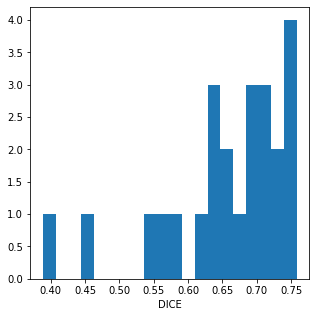

In [44]:
dicesa = np.array(torch.cat(dices).cpu())
plt.hist(dicesa, 20)
plt.xlabel("DICE")
np.mean(dicesa)
ff = np.mean(folds_list)
print(ff)

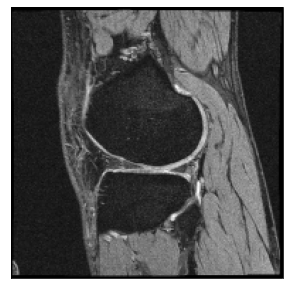

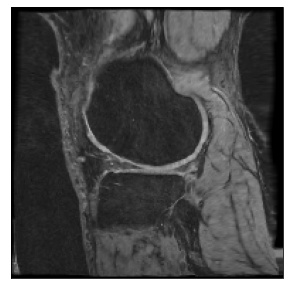

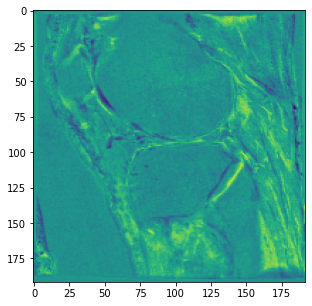

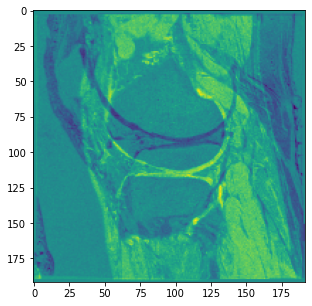

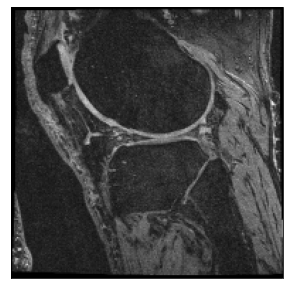

In [11]:



if not("N" in locals()):
    N = 0
#N += 1
N %= 4
N = 3
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()
plt.rcParams["figure.figsize"] = (5, 5)
def imshow(x):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
slice_ = 20
imshow(fixed_image[N, 0, slice_])
plt.show()
imshow(net.warped_image_A[N, 0, slice_])
plt.show()

plt.imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach() - moving_image[N, 0, slice_ ].cpu().detach())
plt.show()
#plt.imshow(net.regis_net.x_comp_phi[N, 0, slice_].cpu().detach() - moving_image[N, 0, slice_].cpu().detach())
#plt.show()
plt.imshow((fixed_image - moving_image)[N, 0, slice_].cpu().detach())
plt.show()

imshow(moving_image[N, 0, slice_].cpu().detach())
plt.show()

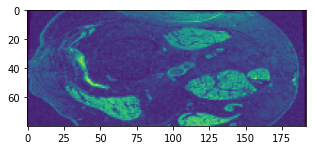

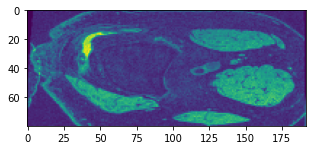

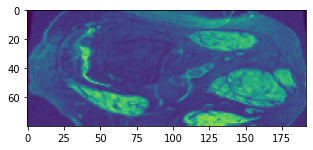

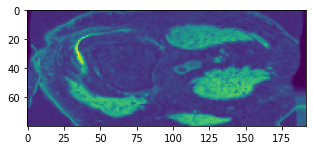

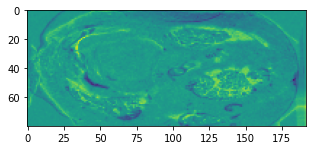

In [11]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach() - moving_image[0, 0, :, 10].cpu())

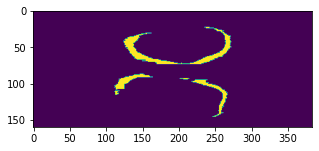

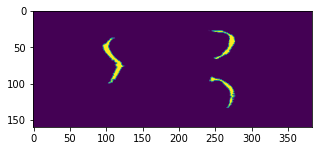

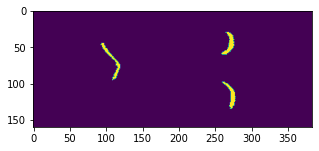

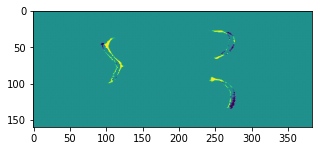

In [12]:

S = 40
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()

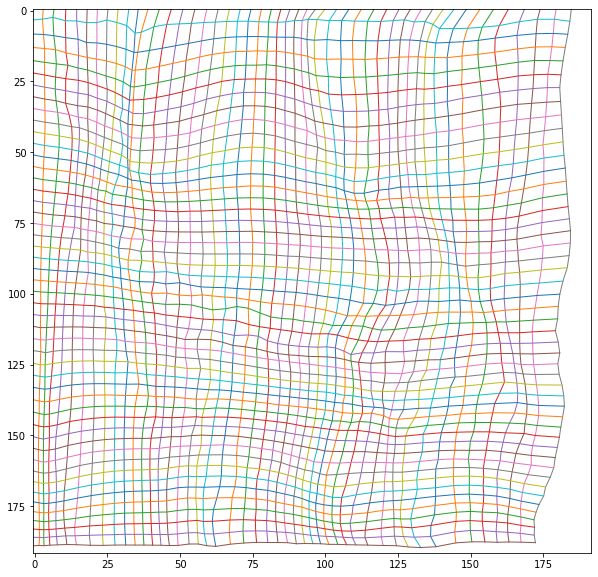

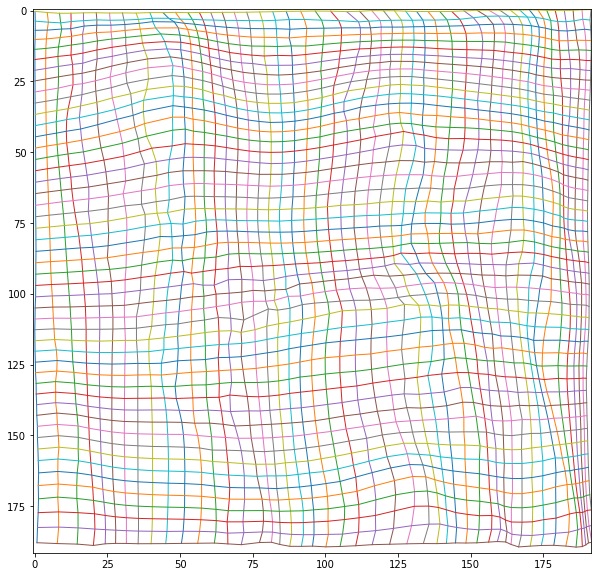

In [13]:
import visualize
N = (N + 1)% 4

plt.rcParams["figure.figsize"] = 10, 10
visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
plt.show()
visualize.show_as_grid(net.phi_BA_vectorfield[N, [1, 2], 20])


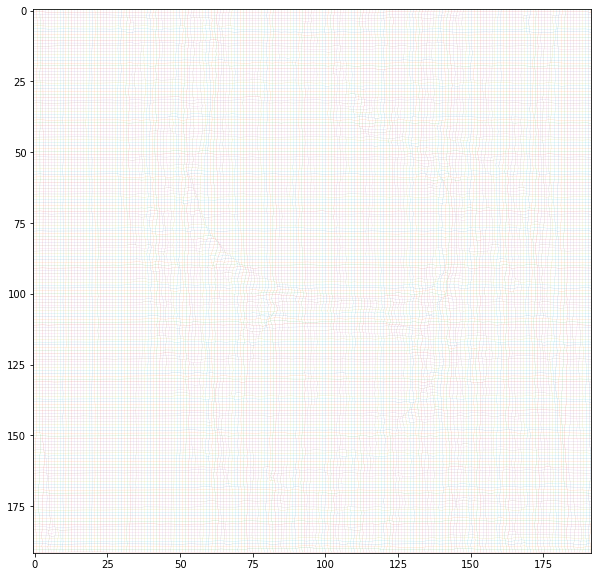

In [109]:
phi = net.phi_AB.__closure__[1]
some_vectorfield = phi.cell_contents.__closure__[1].cell_contents + net.identityMap
visualize.show_as_grid(some_vectorfield[N, [1, 2], 20])

In [110]:
net.phi_AB.__closure__[0].cell_contents

<function network_wrappers.DoubleNet.forward.<locals>.<lambda>(input_)>

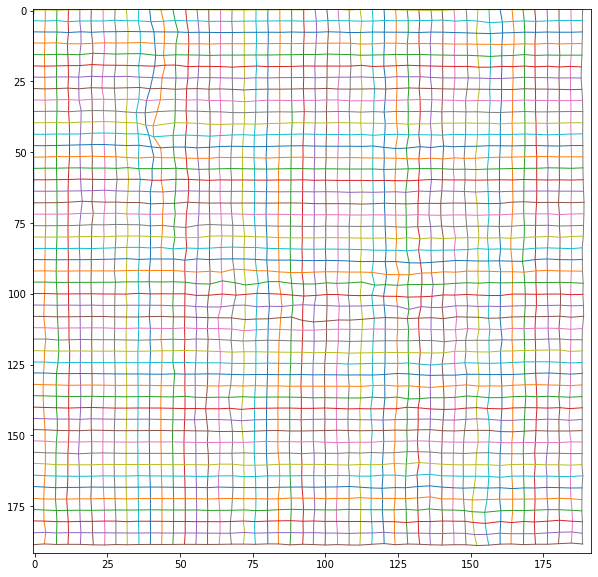

In [14]:
#N = (N + 1) % 4
visualize.show_as_grid(net.phi_BA(net.phi_AB(net.identityMap))[N, [1, 2], 20])

In [128]:
type(net.regisNet.netPhi)

ModuleAttributeError: 'InverseConsistentNet' object has no attribute 'regisNet'

In [129]:
net.lmbda

100

In [130]:
trained_weights.keys()

odict_keys(['identityMap', 'regis_net.identityMap', 'regis_net.netPsi.identityMap', 'regis_net.netPsi.net.identityMap', 'regis_net.netPsi.net.downConvs.0.weight', 'regis_net.netPsi.net.downConvs.0.bias', 'regis_net.netPsi.net.downConvs.1.weight', 'regis_net.netPsi.net.downConvs.1.bias', 'regis_net.netPsi.net.downConvs.2.weight', 'regis_net.netPsi.net.downConvs.2.bias', 'regis_net.netPsi.net.downConvs.3.weight', 'regis_net.netPsi.net.downConvs.3.bias', 'regis_net.netPsi.net.downConvs.4.weight', 'regis_net.netPsi.net.downConvs.4.bias', 'regis_net.netPsi.net.upConvs.0.weight', 'regis_net.netPsi.net.upConvs.0.bias', 'regis_net.netPsi.net.upConvs.1.weight', 'regis_net.netPsi.net.upConvs.1.bias', 'regis_net.netPsi.net.upConvs.2.weight', 'regis_net.netPsi.net.upConvs.2.bias', 'regis_net.netPsi.net.upConvs.3.weight', 'regis_net.netPsi.net.upConvs.3.bias', 'regis_net.netPsi.net.upConvs.4.weight', 'regis_net.netPsi.net.upConvs.4.bias', 'regis_net.netPsi.net.batchNorms.0.weight', 'regis_net.netPs

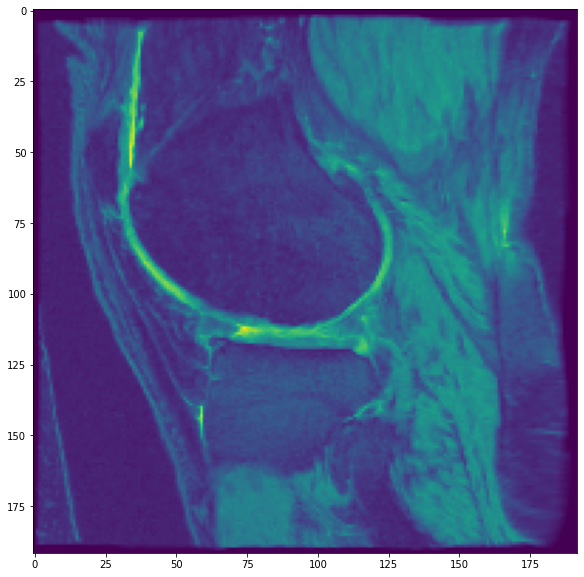

In [85]:
plt.imshow(net.warped_image_B[0, 0, 20].cpu().detach())

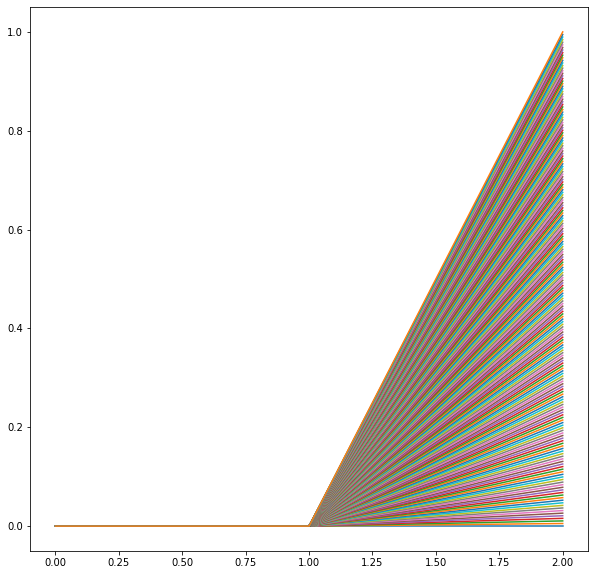

In [38]:
plt.plot(net.regis_net.identityMap[3, :, 0, 0].cpu().numpy())

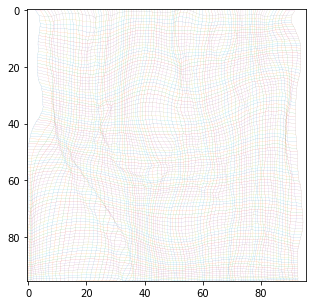

In [67]:
import visualize
mp = hires_Net.phi_AB(hires_Net.regis_net.net.identityMap[:, :] + torch.tensor([[[[[0]]], [[[0]]], [[[0]]]]]).cuda())
visualize.show_as_grid(mp[N, [1, 2], 20])

In [42]:
import mermaidlite

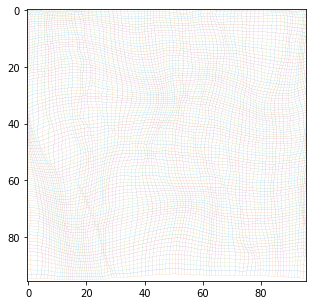

In [70]:
import visualize
mp = pretrained_lowres_net.phi_AB(hires_Net.identityMap[:, :, ::2, ::2, ::2])
visualize.show_as_grid(mp[N, [1, 2], 20])

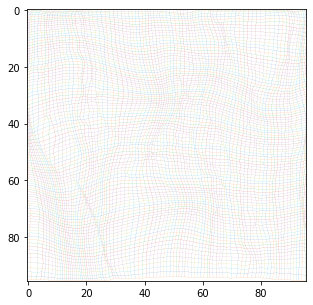

In [73]:
import visualize
mp = hires_Net.phi_BA(hires_Net.regis_net.net.identityMap)
visualize.show_as_grid(mp[N, [1, 2], 20])

In [44]:
mermaidlite.compute_warped_image_multiNC?

In [47]:
torch.nn.functional.avg_pool3d?

tensor([[[[[ 8.9085e-03,  9.2434e-03,  9.5800e-03,  ...,  8.9751e-03,
             9.2738e-03,  9.5502e-03],
           [ 9.2282e-03,  9.6274e-03,  1.0028e-02,  ...,  9.9777e-03,
             1.0269e-02,  1.0568e-02],
           [ 9.5437e-03,  1.0007e-02,  1.0471e-02,  ...,  1.0989e-02,
             1.1275e-02,  1.1593e-02],
           ...,
           [ 1.4196e-02,  1.4902e-02,  1.5630e-02,  ...,  3.1676e-02,
             3.1930e-02,  3.2242e-02],
           [ 1.4148e-02,  1.4913e-02,  1.5682e-02,  ...,  3.1702e-02,
             3.2031e-02,  3.2408e-02],
           [ 1.4288e-02,  1.5008e-02,  1.5746e-02,  ...,  3.1845e-02,
             3.2131e-02,  3.2459e-02]],

          [[ 2.1678e-02,  2.2050e-02,  2.2422e-02,  ...,  2.1415e-02,
             2.1756e-02,  2.2022e-02],
           [ 2.1997e-02,  2.2410e-02,  2.2823e-02,  ...,  2.2525e-02,
             2.2892e-02,  2.3150e-02],
           [ 2.2312e-02,  2.2766e-02,  2.3220e-02,  ...,  2.3641e-02,
             2.4040e-02,  2.4288e-02],
 

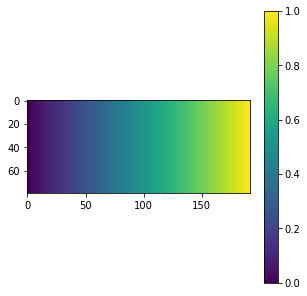

In [51]:
plt.imshow(hires_Net.identityMap[0, 2, :, 0].cpu().numpy())
plt.colorbar()

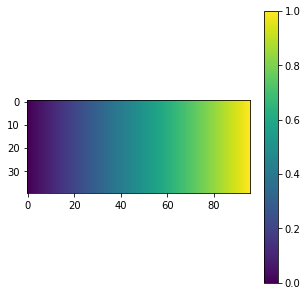

In [50]:
plt.imshow(net.identityMap[0, 2, :, 0].cpu().numpy())
plt.colorbar()

In [59]:
import importlib
import mermaidlite
importlib.reload(mermaidlite)

<module 'mermaidlite' from '/playpen-raid1/tgreer/InverseConsistency/mermaidlite.py'>

In [22]:
dir(net)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval'

In [25]:
net(fixed_image, moving_image)

(tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.4185e-05, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>))

In [27]:
weights_a = torch.load("../results/hires_continue_ramp_lambda3/knee_aligner_resi_net1200")
weights_b = torch.load("../results/hires_continue_ramp_lambda3/knee_aligner_resi_net9900")

In [44]:
weights_a["regis_net.netPsi.net.upConvs.2.weight"].shape

torch.Size([192, 64, 4, 4, 4])

tensor([-0.0072, -0.0064, -0.0167, -0.0075, -0.0135, -0.0068, -0.0109, -0.0210,
        -0.0091,  0.0195, -0.0205, -0.0089,  0.0141,  0.0079, -0.0024, -0.0181,
        -0.0125,  0.0085,  0.0196,  0.0138,  0.0020, -0.0112,  0.0030, -0.0125,
         0.0145,  0.0118,  0.0001, -0.0132, -0.0191, -0.0011, -0.0219,  0.0162],
       device='cuda:0')

In [40]:
weights_a.keys()

odict_keys(['identityMap', 'regis_net.identityMap', 'regis_net.netPsi.identityMap', 'regis_net.netPsi.net.identityMap', 'regis_net.netPsi.net.downConvs.0.weight', 'regis_net.netPsi.net.downConvs.0.bias', 'regis_net.netPsi.net.downConvs.1.weight', 'regis_net.netPsi.net.downConvs.1.bias', 'regis_net.netPsi.net.downConvs.2.weight', 'regis_net.netPsi.net.downConvs.2.bias', 'regis_net.netPsi.net.downConvs.3.weight', 'regis_net.netPsi.net.downConvs.3.bias', 'regis_net.netPsi.net.downConvs.4.weight', 'regis_net.netPsi.net.downConvs.4.bias', 'regis_net.netPsi.net.upConvs.0.weight', 'regis_net.netPsi.net.upConvs.0.bias', 'regis_net.netPsi.net.upConvs.1.weight', 'regis_net.netPsi.net.upConvs.1.bias', 'regis_net.netPsi.net.upConvs.2.weight', 'regis_net.netPsi.net.upConvs.2.bias', 'regis_net.netPsi.net.upConvs.3.weight', 'regis_net.netPsi.net.upConvs.3.bias', 'regis_net.netPsi.net.upConvs.4.weight', 'regis_net.netPsi.net.upConvs.4.bias', 'regis_net.netPsi.net.batchNorms.0.weight', 'regis_net.netPs

In [19]:
mkdir Roland_result


In [27]:
import importlib
importlib.reload(visualize)
for N in range(4):

    plt.rcParams["figure.figsize"] = (5, 5)
    def imshow(x):
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
    slice_ = 20
    imshow(moving_image[N, 0, slice_].cpu().detach())
    plt.savefig(f"Roland_result/Pair{N}ImageA.png")
    plt.clf()
    imshow(fixed_image[N, 0, slice_])
    plt.savefig(f"Roland_result/Pair{N}ImageB.png")
    plt.clf()
    imshow(net.warped_image_A[N, 0, slice_])
    plt.savefig(f"Roland_result/Pair{N}WarpedImageA.png")
    plt.clf()
    imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach())
    plt.savefig(f"Roland_result/Pair{N}WarpedImageB.png")
    plt.clf()
    imshow(net.warped_image_B[N, 0, slice_].cpu().detach())
    visualize.show_as_grid(net.phi_BA_vectorfield[N, [1, 2], 20])
    plt.savefig(f"Roland_result/Pair{N}WarpedImageBGrid.png")
    plt.clf()
    imshow(net.warped_image_A[N, 0, slice_].cpu().detach())
    visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
    plt.savefig(f"Roland_result/Pair{N}WarpedImageAGrid.png")
    plt.clf()

    
    plt.show()

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>